In [1]:
%matplotlib widget
import numpy as np
import scipy
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from scipy.signal import spectrogram
import datetime
from geopy.distance import distance

In [2]:
# set path and data parameters
path = "/media/Data/Data/YT/"
stats = ["BEAR","THUR","DNTW","UPTW"]
chans = "BH*"

# set path to XML response file
inv = obspy.Inventory()
for stat in stats:
    pathXML = path + "XML/" + "/*" + stat + ".xml"
    inv += obspy.read_inventory(pathXML)

In [ ]:
'''

Read data, remove instrumental response, and basic preprocessing for entire window constrained by TerraSAR-X data

'''

# set day of interest
year = "2012"
month = "05"
day = "09"

# read in traces without instrument response removed
files = [path + "MSEED/raw/" + stat + "/*" + chans + "__" + year + month + day + "T000000Z__" + "*" for stat in stats]

# read in raw data
st_raw = obspy.Stream()
for f in files:
    st_raw += obspy.read(f)

# merge streams from corresponding stations and channels
st_raw.merge()
    
# basic preprocessing
st_raw.detrend("demean")
st_raw.detrend("linear")
st_raw.taper(max_percentage=0.00025, max_length=20.)

# remove response to lowest desired frequency
st_1000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.0005,0.001,15,20],output="VEL")

# save full-resolution data
st_event = st_1000s.copy().trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,23,59))
st_event.write("data/MSEED/may_9_event_regional_velocity_1000s.MSEED")
st_1000s.write("data/MSEED/2012-05-09_regional_velocity_1000s.MSEED")

# save downsampled data
st_1000s_downsampled = st_1000s.resample(1)
st_1000s_downsampled.write("data/MSEED/2012-05-09_regional_velocity_1000s_downsampled.MSEED")
st_raw_downsampled = st_raw.resample(1)
st_raw_downsampled.write("data/MSEED/2012-05-09_regional_velocity_raw_downsampled.MSEED")

In [ ]:
'''

Make spectrogram of the event

'''

# set parameters
stations = ["DNTW","THUR"]
channels = ["BHZ"]
fs = 40
low_cut = 1

for station in stations:
        for channel in channels:
            # read data
            st = obspy.read("data/MSEED/may_9_event_regional_velocity_1000s.MSEED")

            # filter and trim data
            st.filter("highpass",freq=low_cut)
            st.trim(starttime=obspy.UTCDateTime(2012,5,9,18),endtime=obspy.UTCDateTime(2012,5,9,18,30))
            st.taper(max_percentage=0.01,max_length=20)

            # make plot
            fig,ax = plt.subplots(2,1,figsize=[10,10],gridspec_kw={'height_ratios': [1, 3]})

            # plot data
            times = [t.datetime for t in st[2].times("UTCDateTime")]
            ticks = [times[len(times)//8],times[len(times)//4],times[len(times)//8*3],times[len(times)//2],times[len(times)//8*5],times[len(times)//4*3],times[len(times)//8*7],times[len(times)-1]]
            ax[0].plot(times,st.select(channel=channel,station=station)[0].data*1000,'k')
            ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax[0].grid(True)
            box = ax[0].get_position()
            box.y0 = box.y0 - 0.1
            box.y1 = box.y1 - 0.1
            ax[0].set_position(box)
            ax[0].set_ylabel("Velocity (mm/s)")    
            ax[0].set_title(station+" "+channel)

            # make spectrogram
            f,t,s = spectrogram(st.select(station=station,channel=channel)[0].data*1000, fs=fs, nperseg=300)

            # plot spectrogram 
            times = [datetime.datetime(2012,5,9,18) + datetime.timedelta(seconds=time) for time in t]
            vrange = np.log10(np.max(s))-np.log10(np.min(s))
            spec = ax[1].pcolor(times, np.log10(f), np.log10(s), vmin=np.log10(np.min(s))+vrange*0.5,vmax=np.log10(np.max(s)))
            ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax[1].get_shared_x_axes().join(ax[0],ax[1])
            ax[1].set_xticks(ticks)
            ax[1].set_xlim([times[0],times[-1]])
            ax[1].set_yticks([np.log10(low_cut),0,1])
            ax[1].set_ylim([-0.5,np.log10(np.max(f))])
            ax[1].set_yticklabels(["$10^{-1}$","$10^{0}$","$10^{1}$"])
            ax[1].set_ylabel("Frequency (Hz)")
            ax[1].set_xlabel("Time")
            plt.subplots_adjust(right=0.85)
            cbar_ax = fig.add_axes([0.9, 0.1225, 0.025, 0.5])
            cbar = plt.colorbar(spec,label="PSD (mm$^2$/Hz)",ticks=[-13,-12,-11,-10,-9],cax=cbar_ax)
            cbar.ax.set_yticklabels(['$10^{-13}$','$10^{-12}$','$10^{-11}$', '$10^{-10}$', '$10^{-9}$']) 
            plt.savefig("outputs/"+station + "_" + channel + "_spectrogram.png")

Dominant BHZ frequency(THUR): 1.54433719881 Hz
Dominant BHZ frequency(DNTW): 1.55822512326 Hz


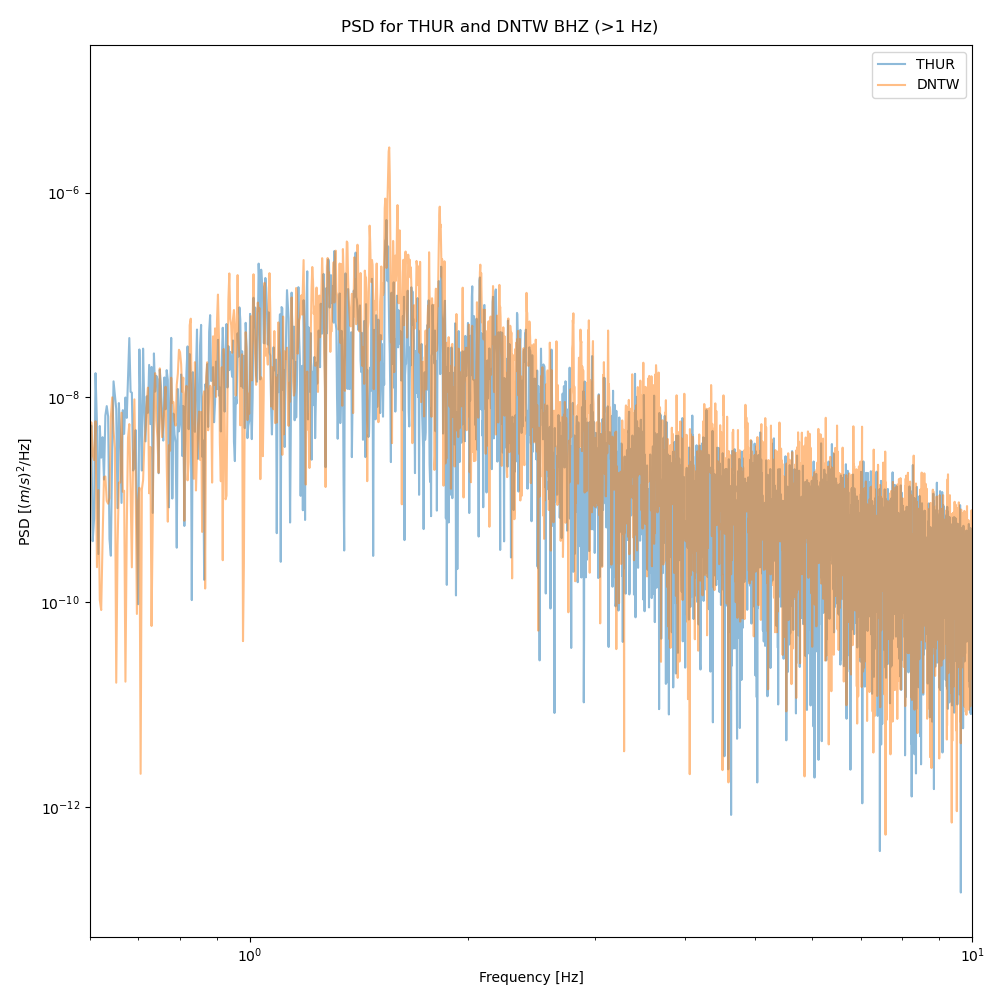

Observed frequency shift: 0.0138879244497 Hz


In [201]:
'''

Make periodogram of signal at THUR and DNTW 

'''

# select station and component
stations = ["THUR","DNTW"]
channel = "BHZ"
method = "fft"

# read and preprocess data
st = obspy.read("data/MSEED/may_9_event_regional_velocity_1000s.MSEED")
low_cut = 1
high_cut = 10
st.filter("bandpass",freqmin=low_cut,freqmax=high_cut)
st.taper(max_percentage=0.01,max_length=20)
st.trim(starttime=obspy.UTCDateTime(2012,5,9,18,3),endtime=obspy.UTCDateTime(2012,5,9,18,9))

# make plot of spectra
fig, ax = plt.subplots(1,figsize=(10,10))
characteristic_freqs = []
spectra_list = []
for i in range(len(stations)):
    data = st.select(station=stations[i],channel=channel)[0].data
    if method == "fft":
        spectra = abs(np.fft.rfft(data))
        f = np.fft.fftfreq(len(data), d=1/st[0].stats.sampling_rate)
        f = f[:len(f)//2+1]
        power = np.square(spectra)
        psd = power/(f[1]-f[0])
        ax.plot(f,psd,label=stations[i],alpha=0.5)
    
    elif method == "welch":
        f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=2000,noverlap=1)
        ax.plot(f,psd,label=stations[i],linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('PSD [$(m/s)^2$/Hz]')
    ax.set_xlim([0.6,10])
    above_low_cut = [f>low_cut]
    below_high_cut = [f<high_cut]
    in_band = np.logical_and(above_low_cut,below_high_cut)[0]
    ax.set_ylim([np.min(psd[in_band]/10),np.max(psd[in_band])*10])
    spectra_list.append(psd)

    # report dominant period
    characteristic_freqs.append(f[np.argmax(psd)])
    print("Dominant " + channel + " frequency(" + stations[i] + "): " + str(f[np.argmax(psd)]) + " Hz")

ax.legend()
plt.suptitle("PSD for " + stations[0] + " and " + stations[1] + " " + channel + " (>" + str(low_cut)+" Hz)")
plt.tight_layout() 
plt.show()
print("Observed frequency shift: " + str(np.diff(characteristic_freqs)[0]) + " Hz")

In [198]:
# cross correlate the spectra to find frequency shift
low_cut = 0.6
high_cut = 2.65
above_low_cut = [f>low_cut]
below_high_cut = [f<high_cut]
in_band = np.logical_and(above_low_cut,below_high_cut)[0]
norm_spectra_0 = spectra_list[0][in_band]/np.max(spectra_list[0][in_band])
norm_spectra_1 = spectra_list[1][in_band]/np.max(spectra_list[1][in_band])
cc = scipy.signal.correlate(norm_spectra_0,norm_spectra_1)
lags = scipy.signal.correlation_lags(len(spectra_list[0][in_band]),len(spectra_list[1][in_band]))
ind = np.argmax(cc)
max_shift = abs(lags[ind])

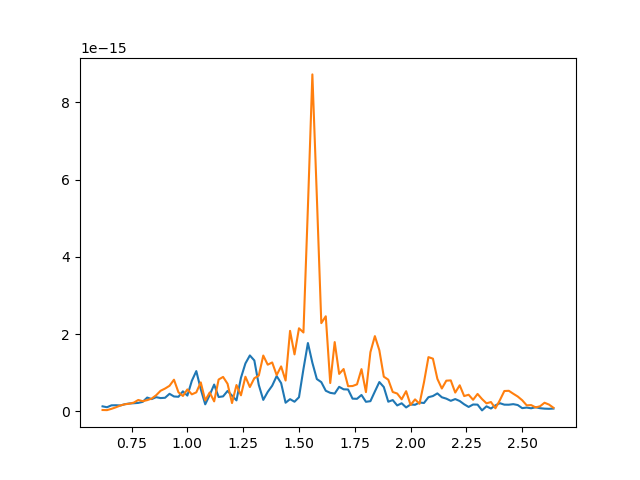

In [199]:
plt.figure()
env_0 = np.abs(scipy.signal.hilbert(spectra_list[0][in_band]))
env_1 = np.abs(scipy.signal.hilbert(spectra_list[1][in_band]))
plt.plot(f[in_band],env_0)
plt.plot(f[in_band],env_1)
plt.show()

# Relating rupture speed to Doppler shift at two stations
$\begin{align}
\text{In front of rift:} \hspace{0.5cm} f_{front} = f_f = \frac{v + v_o}{v - v_s} f\\
\text{Behind rift:} \hspace{0.5cm} f_{behind} = f_b = \frac{v + v_o}{v + v_s} f\\
\text{Observer velocity is zero:} \hspace{0.5cm} f_f = \frac{v}{v-v_s}f \hspace{0.5cm} \text{and} \hspace{0.5cm} f_b = \frac{v}{v+v_s}f\\
\frac{f_f}{f_b} = \left(\frac{v}{v-v_s}f\right) \div \left(\frac{v}{v+v_s}f\right)\\
\frac{f_f}{f_b} = \frac{v+v_s}{v-v_s}\\
f_f(v-v_s) = f_b(v+v_s)\\
f_fv-f_fv_s = f_bv+f_bv_s\\
f_fv - f_bv = f_fv_s+f_bv_s\\
v(f_f - f_b) = v_s(f_b+f_f)\\
v_s = v\frac{f_f-f_b}{f_f + f_b}
\end{align}$

Velocity estimated using arrival at THUR: 3942.89809252 m/s
Velocity estimated using arrival at DNTW: 3979.78084565 m/s


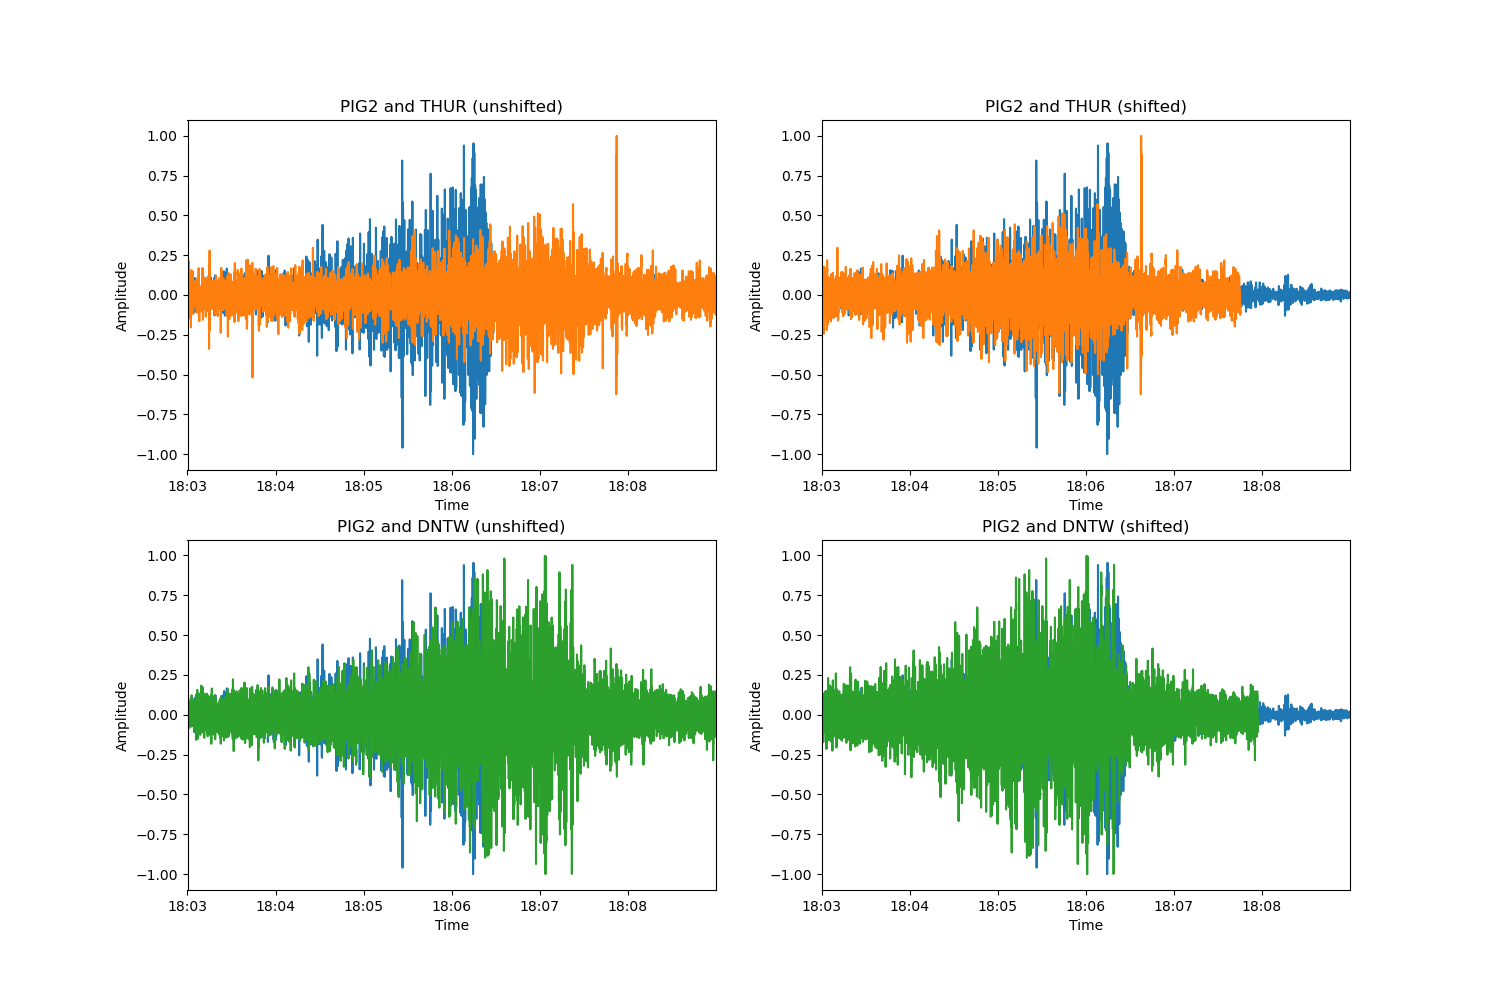

In [108]:
'''

Estimate phase velocity of the signal recorded at DNTW and THUR

'''

# read data
st_local = obspy.read("data/MSEED/may_9_event_velocity_100000s.MSEED")
st_regional = obspy.read("data/MSEED/may_9_event_regional_velocity_1000s.MSEED")
    
# filter and trim data
low_cut = 1
st_local.filter("highpass",freq=low_cut)
st_local.taper(max_percentage=0.01,max_length=20)
st_local.trim(starttime=obspy.UTCDateTime(2012,5,9,18,3),endtime=obspy.UTCDateTime(2012,5,9,18,9))
st_regional.filter("highpass",freq=low_cut)
st_regional.taper(max_percentage=0.01,max_length=20)
st_regional.trim(starttime=obspy.UTCDateTime(2012,5,9,18,3),endtime=obspy.UTCDateTime(2012,5,9,18,9))

# only get stations of interest
st_local = st_local.select(station="PIG2",channel="HHZ")
st_regional = obspy.Stream(st_regional.select(station="THUR",channel="BHZ").append(st_regional.select(station="DNTW",channel="BHZ")[0]))

# resample HH data to BH sampling rate
st_local.resample(st_regional[0].stats.sampling_rate)
times = [t.datetime for t in st_local[0].times("UTCDateTime")]

# cross correlate to estimate delay time, calculate station separation, and estimate phase velocity
fig,ax = plt.subplots(len(st_regional),2,figsize=[15,10])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1:]
for stat in range(len(st_regional)):
    
    # do the cross correlation
    tr = st_regional[stat]
    cc = correlate(st_local[0],tr,7000)
    shift,value = xcorr_max(cc)
    delay = shift/st_regional[0].stats.sampling_rate
    
    # plot waveforms
    ax[stat][0].plot(times,st_local[0].data/np.max(np.abs(st_local[0].data)))
    ax[stat][0].plot(times,st_regional[stat].data[:-1]/np.max(np.abs(st_regional[stat].data)),color=colors[stat])
    ax[stat][1].plot(times,st_local[0].data/np.max(np.abs(st_local[0].data)))
    ax[stat][1].plot(times[:-int(np.abs(shift))],st_regional[stat].data[int(np.abs(shift)):-1]/np.max(np.abs(st_regional[stat].data)),color=colors[stat])
    ax[stat][0].set_xlim(times[0],times[-1])
    ax[stat][1].set_xlim(times[0],times[-1])
    ax[stat][0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[stat][0].set_xlabel("Time")
    ax[stat][0].set_ylabel("Amplitude")
    ax[stat][1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[stat][1].set_xlabel("Time")
    ax[stat][1].set_ylabel("Amplitude")
    ax[stat][0].set_title(st_local[0].stats.station + " and " + tr.stats.station + " (unshifted)")
    ax[stat][1].set_title(st_local[0].stats.station + " and " + tr.stats.station + " (shifted)")

    # get station locations and calculate distance
    inv_local = obspy.read_inventory("data/XML/*"+st_local[0].stats.station+".XML")
    channel_local = st_local[0].stats.network + "." + st_local[0].stats.station + "..HHZ"
    lat_lon_local = [inv_local.get_coordinates(channel_local)["latitude"],inv_local.get_coordinates(channel_local)["longitude"]]
    inv_regional = obspy.read_inventory("data/XML/*"+tr.stats.station+".XML")
    channel_regional = tr.stats.network + "." + tr.stats.station + "..BHZ"
    lat_lon_regional = [inv_regional.get_coordinates(channel_regional)["latitude"],inv_regional.get_coordinates(channel_regional)["longitude"]]
    station_distance = distance(lat_lon_local,lat_lon_regional).m
    velocity = station_distance/(-1*delay)
    print("Velocity estimated using arrival at " + tr.stats.station + ": " + str(velocity) + " m/s")

In [67]:
'''

Estimate rupture speed using directivity

'''

def get_dominant_frequency(data,fs,method):
    if method == "fft":
        spectra = abs(np.fft.rfft(data))
        f = np.fft.fftfreq(len(data), d=1/fs)
        power = np.square(spectra)
        psd = power/(f[1]-f[0])
    elif method == "welch":
        f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=300,noverlap=0)
    dom_freq = f[np.argmax(psd)]
    return dom_freq

# read and preprocess data
st = obspy.read("data/MSEED/may_9_event_regional_velocity_1000s.MSEED")
low_cut = 1
st.filter("highpass",freq=low_cut)
st.taper(max_percentage=0.01,max_length=20)
st.trim(starttime=obspy.UTCDateTime(2012,5,9,18,3),endtime=obspy.UTCDateTime(2012,5,9,18,9))

data_f = st.select(station="DNTW",channel="BHZ")[0].data
data_b = st.select(station="THUR",channel="BHZ")[0].data

# set two frequencies
f_f = get_dominant_frequency(data_f,st[0].stats.sampling_rate,"welch")
f_b = get_dominant_frequency(data_b,st[0].stats.sampling_rate,"welch")

# set phase velocity
v = 3950

# calculate rupture speed
v_s = (f_f-f_b)/(f_b+f_f)*v

# estimate event duration
length = 7000
duration = length/v_s

# print results
print("Estimated rupture velocity: " + str(v_s) + " m/s")
print("Estimated duration: " + str(duration) + " s")

Estimated rupture velocity: 359.090909091 m/s
Estimated duration: 19.4936708861 s


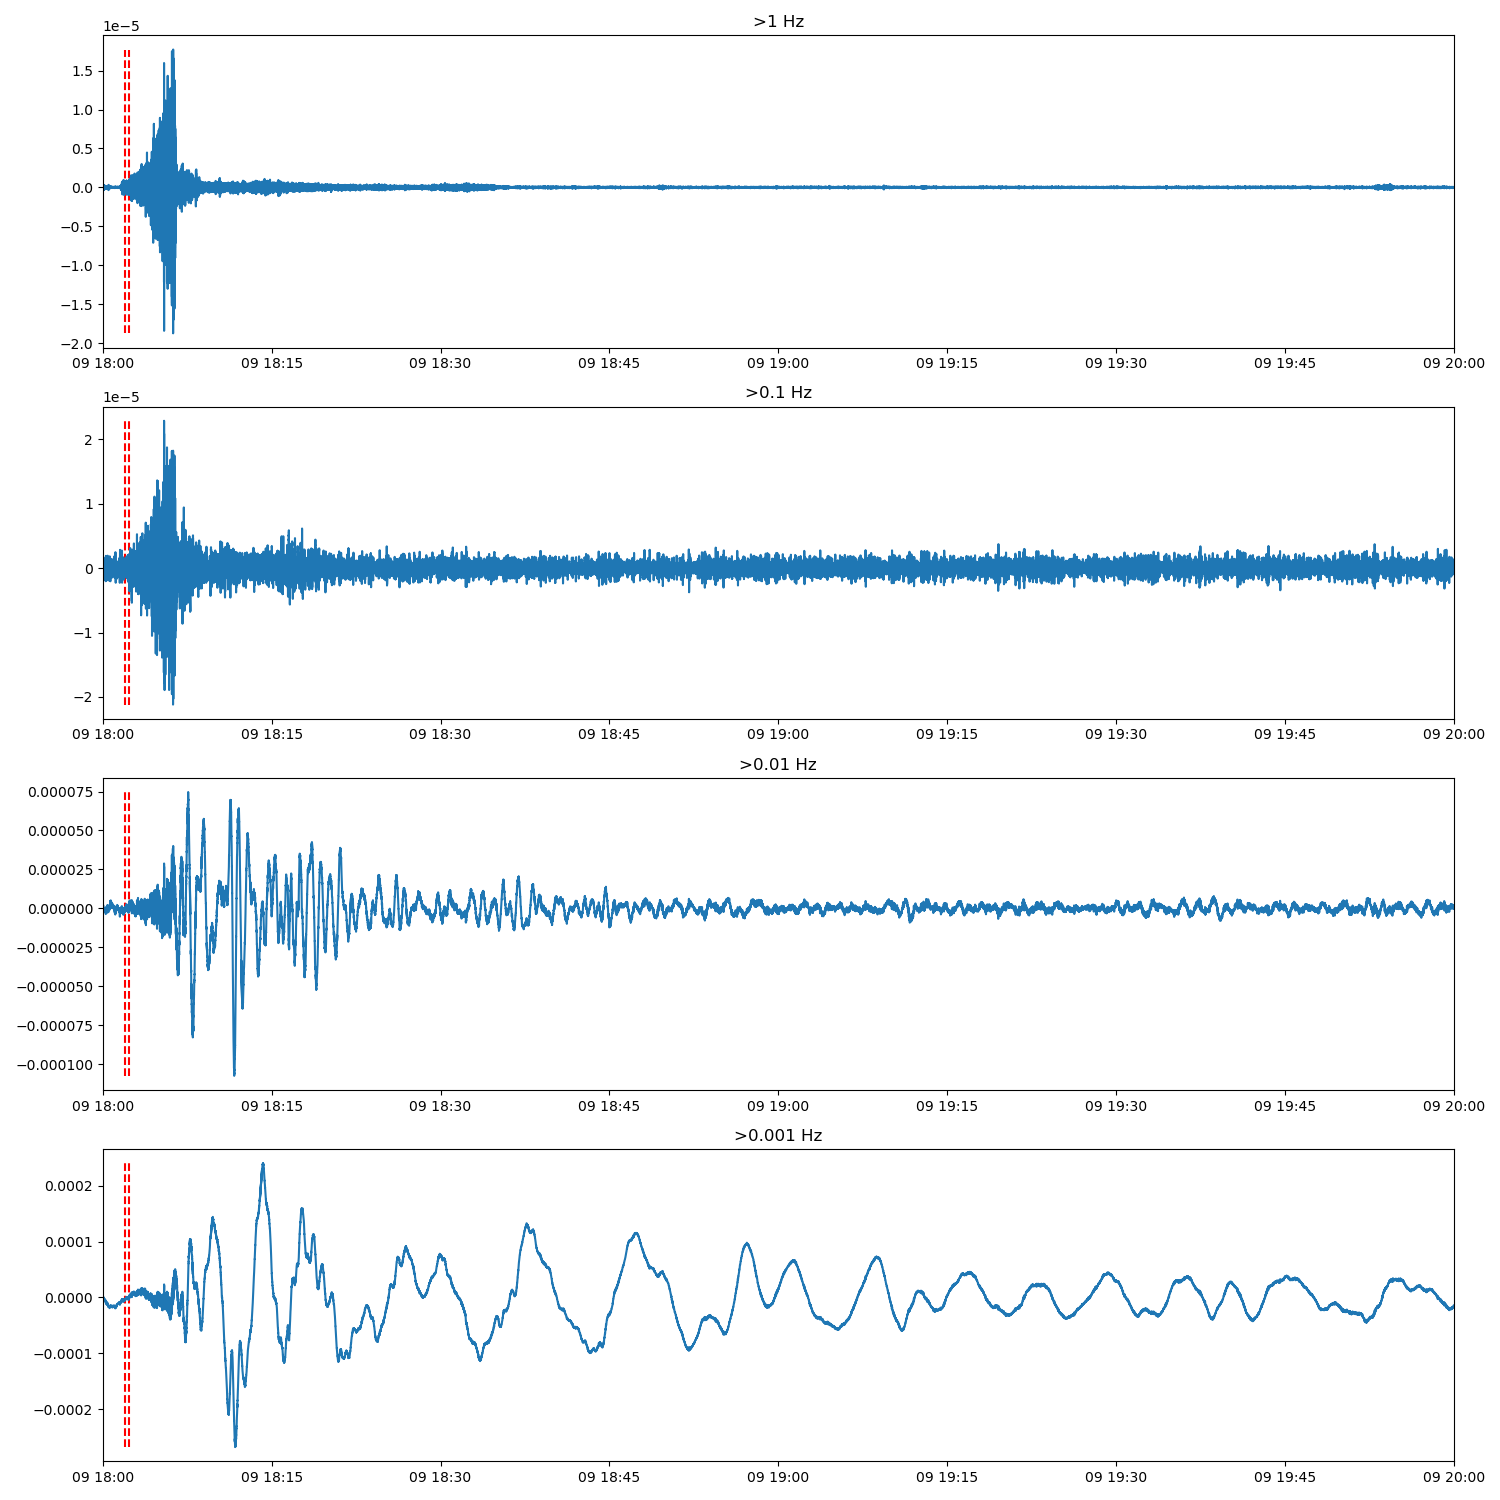

In [68]:
'''

Make a figure showing the rupture duration with waveforms

'''

st = obspy.read("data/MSEED/may_9_event_velocity_100000s.MSEED")
st = st.select(station="PIG2",channel="HHZ")
freqs = [1,0.1,0.01,0.001]

fig,ax=plt.subplots(len(freqs),1,figsize=[15,15])
for f in range(len(freqs)):
    st_filt = st.copy().filter("highpass",freq=freqs[f])
    st_filt.taper(max_percentage=0.01,max_length=20)
    st_filt.trim(starttime=obspy.UTCDateTime(2012,5,9,18),endtime=obspy.UTCDateTime(2012,5,9,20))
    data = st_filt[0].data
    times = [t.datetime for t in st_filt[0].times("UTCDateTime")]
    ax[f].plot(times,data)
    ax[f].set_title(">"+str(freqs[f])+" Hz")
    ax[f].vlines([datetime.datetime(2012,5,9,18,2),datetime.datetime(2012,5,9,18,2)+datetime.timedelta(seconds=duration)],min(data),max(data),linestyle='--',color='r')
    ax[f].set_xlim([times[0],times[-1]])
plt.tight_layout()
plt.show()